# Inspection of DC2 Object Table 
### Michael Wood-Vasey (@wmwv)

1. Make density plots (e.g., `hexbin`, `hist2d`, `datashader`) of
    - ra, dec
    - u-g, g-r
    - r-i, g-r
    - i-z, g-r
    - z-y, g-r
2. Make 1D density plots (e.g., `hist`, kernel-density-estimation)
    - N({ugrizy})
    - Shape parameters

Verification:  
Compare GCR access and DPDD Parquet file.

In [1]:
# Insert development version of gcr-catalogs/issues/254
import sys
sys.path.insert(0, '/global/homes/w/wmwv/local/lsst/gcr-catalogs')

In [2]:
import os

import numpy as np
import pandas as pd

import GCRCatalogs

In [141]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

import seaborn as sns

In [4]:
# cmap = 'Oranges'
cmap = 'viridis_r'

## Load Data

In [5]:
catalog_name = 'dc2_object_run1.2i_with_photoz'

In [6]:
cat = GCRCatalogs.load_catalog(catalog_name)

In [7]:
# The cat object knows about its base directory
# We'll look there for the Parquet file
# dpdd_parquet_file = 'dpdd_{}.parquet'.format(catalog_name)
# dpdd_parquet_dir = cat.base_dir
dpdd_parquet_file = 'dpdd_dc2_object_run1.2i.parquet'
dpdd_parquet_dir = '/global/projecta/projectdirs/lsst/global/in2p3/Run1.2i/object_catalog_new'

dpdd_parquet_file = 'dpdd_dc2_object_run1.2p.parquet'
dpdd_parquet_dir = '/global/projecta/projectdirs/lsst/global/in2p3/Run1.2p/object_catalog_v4'


dpdd_parquet_file = os.path.join(dpdd_parquet_dir, dpdd_parquet_file)

In [8]:
df = pd.read_parquet(dpdd_parquet_file)

## Object Density in RA, Dec

DC2 Run 1.x Main region
https://docs.google.com/document/d/1aQOPL9smeDlhtlwDrp39Zuu2q8DKivDaHLQX3_omwOI/view

| Location        | RA (degrees) | Dec (degrees) |
|:--------------- |:------------ |:------------- |
Center            | 55.064       | -29.783
North-East Corner | 57.87        | -27.25
North-West Corner | 52.25        | -27.25
South-West Corner | 52.11        | -32.25
South-East Corner | 58.02        | -32.25

In [9]:
dc2_run1x_region = [[57.87, -27.25], [52.25, -27.25], [52.11, -32.25], [58.02, -32.25]]

In [10]:
region = Polygon(dc2_run1x_region)

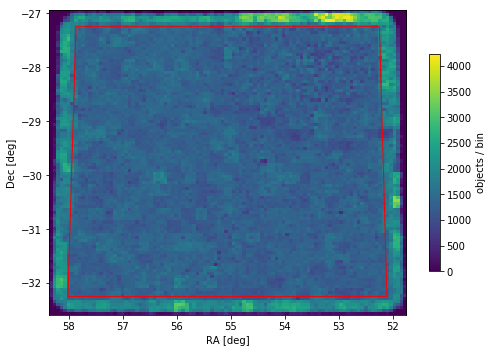

In [11]:
fig = plt.figure(figsize=(8, 8))
ax = plt.gca()
ax.set_aspect(1)

plt.hist2d(df['ra'], df['dec'], bins=100)
plt.xlim(plt.xlim()[::-1])  # Flip to East left
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.colorbar(shrink=0.5, label='objects / bin')

region = Polygon(dc2_run1x_region, color='red', fill=False)
ax.add_patch(region);

plt.savefig('%s_ra_dec.png' % catalog_name)

In [12]:
# Select good detections:
#  1. Marked as 'good' in catalog flags.
#  2. SNR in given band > threshold
#  3. In defined simulation range
snr_threshold = 3
snr_filter = 'i'
snr = df['psFlux_%s' % snr_filter] / df['psFluxErr_%s' % snr_filter]

In [13]:
def inside_trapezoid(corners, ra, dec):
    # This is a slightly tedious way of defining a symmetric trapezoid
    # Could consider using geopandas, but that adds dependency
    dec_size = corners[1][1] - corners[2][1] # deg

    ra_left_side_delta = corners[1][0] - corners[2][0]
    ra_right_side_delta = corners[0][0] - corners[3][0]
    ra_left_side_slope = ra_left_side_delta / dec_size
    ra_right_side_slope = ra_right_side_delta / dec_size

    inside_ra = (corners[2][0] + ra_left_side_slope * (df['dec'] - corners[2][1]) < df['ra']) & \
                (df['ra'] < corners[3][0] + ra_right_side_slope * (df['dec'] - corners[3][1]))
    inside_dec = (corners[2][1] < df['dec']) & (df['dec'] < corners[1][1])
    return inside_ra & inside_dec

In [14]:
inside = inside_trapezoid(dc2_run1x_region, df['ra'], df['dec'])
good = df[(df['good']) & (snr > snr_threshold) & inside]

In [15]:
stars = good[good['extendedness'] == 0]
galaxies = good[good['extendedness'] > 0]

In [16]:
print(len(df), len(good), len(stars), len(galaxies))

13703802 3785814 958858 2770913


In [17]:
def plot_ra_dec(cat):
    """We're just doing this on a rectilearn grid.
    We should do a projection, of course, but that distortion is minor in this space."""
    fig = plt.figure(figsize=(8, 8))
    ax = plt.gca()
    ax.set_aspect(1)

    plt.hist2d(cat['ra'], cat['dec'], bins=100)
    plt.xlim(plt.xlim()[::-1])  # Flip to East left
    plt.xlabel('RA [deg]')
    plt.ylabel('Dec [deg]')
    plt.colorbar(shrink=0.5, label='objects / bin')

    region = Polygon(dc2_run1x_region, color='red', fill=False)
    ax.add_patch(region);

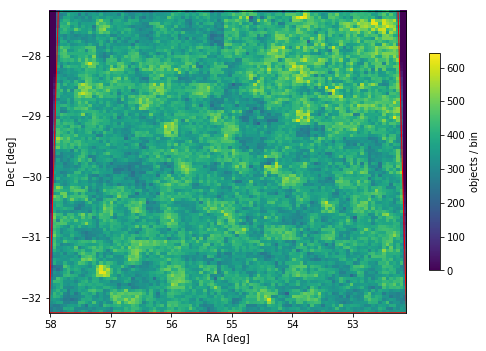

In [18]:
plot_ra_dec(good)
plt.savefig('%s_good_inside_ra_dec.png' % catalog_name)

## Color-Color Diagrams and the Stellar Locus

In [19]:
def get_stellar_locus_davenport(color1='gmr', color2='rmi',
                                datafile='assets/Davenport_2014_MNRAS_440_3430_table1.txt'):
    data = pd.read_table(datafile, sep='\s+', header=1)
    return data[color1], data[color2]
    
    
def plot_stellar_locus(color1='gmr', color2='rmi',
                       color='red', linestyle='--', linewidth=2.5,
                       ax=None):
    model_gmr, model_rmi = get_stellar_locus_davenport(color1, color2)
    plot_kwargs = {'linestyle': linestyle, 'linewidth': linewidth, 'color': color,
                   'scalex': False, 'scaley': False}
    if not ax:
        ax = fig.gca()

    ax.plot(model_gmr, model_rmi, **plot_kwargs)

In [20]:
def plot_color_color(z, color1, color2, 
                     range1=(-1, +2), range2=(-1, +2), bins=31,
                     ax=None, figsize=(4,4)):
    """Plot a color-color diagram.  Overlay stellar locus"""
    band1, band2 = color1[0], color1[-1]
    band3, band4 = color2[0], color2[-1]
    H, xedges, yedges = np.histogram2d(
        z['mag_%s' % band1] - z['mag_%s' % band2],
        z['mag_%s' % band3] - z['mag_%s' % band4],
        range=(range1, range2), bins=bins)
        
    zi = H.T
    xi = (xedges[1:] + xedges[:-1])/2
    yi = (yedges[1:] + yedges[:-1])/2

    if not ax:
        fig = plt.figure(figsize=figsize)
        ax = fig.gca()

    ax.pcolormesh(xi, yi, zi, cmap=cmap)
    ax.contour(xi, yi, zi)
    ax.set_xlabel('%s-%s' % (band1, band2))
    ax.set_ylabel('%s-%s' % (band3, band4))

    try:
        plot_stellar_locus(color1, color2, ax=ax)
    except KeyError as e:
        print("Couldn't plot Stellar Locus model for %s, %s" % (color1, color2))

In [21]:
def plot_four_color_color(cat):
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))

    colors = ['umg', 'rmi', 'imz', 'zmy']
    ref_color = 'gmr'
    for ax, color in zip(axes.flat, colors):
        plot_color_color(cat, ref_color, color, ax=ax)

/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


Couldn't plot Stellar Locus model for gmr, zmy


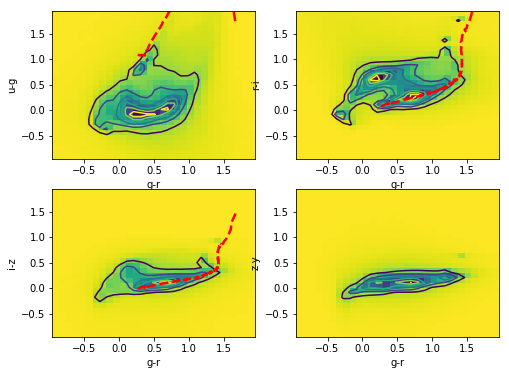

In [22]:
plot_four_color_color(good)
plt.savefig('%s_color_color.png' % catalog_name)

Couldn't plot Stellar Locus model for gmr, zmy


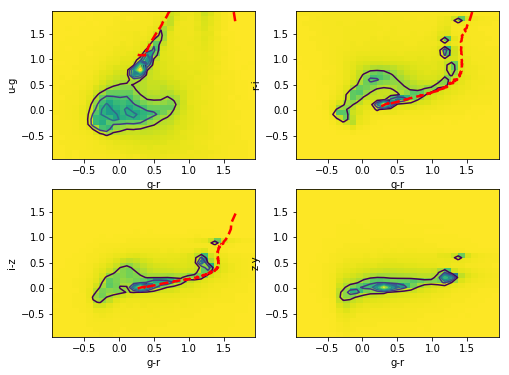

In [23]:
plot_four_color_color(stars)
plt.savefig('%s_stars_color_color.png' % catalog_name)

Couldn't plot Stellar Locus model for gmr, zmy


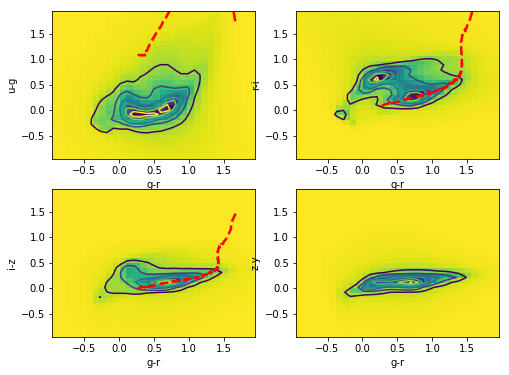

In [24]:
plot_four_color_color(galaxies)
plt.savefig('%s_galaxies_color_color.png' % catalog_name)

## 1D Density Plots

In [25]:
def plot_mag(filt):
    mag = 'mag_%s' % filt
    plt.hist([good[mag], stars[mag], galaxies[mag]],
             label=['all', 'star', 'galaxy'],
             range=(16, 30),
             bins=np.linspace(16, 30, 100),
             histtype='step')
    plt.xlabel(filt)
    plt.ylabel('objects / bin')
    plt.legend()

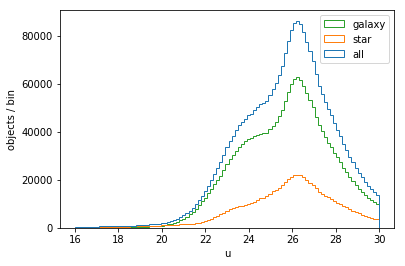

In [26]:
plot_mag('u')

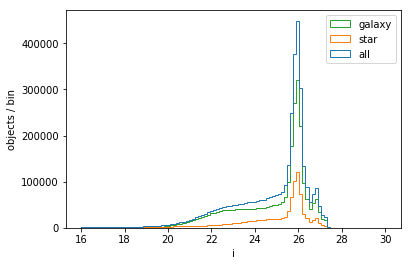

In [27]:
plot_mag('i')

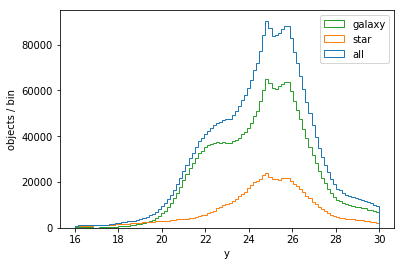

In [28]:
plot_mag('y')

Hmmm... what's that second bump in the i-band histogram from?
Let's select those points and plot them in space and color.

In [29]:
mag_threshold = 26.5
faint_bump_rows = good['mag_i'] > mag_threshold
faint_bump = good[faint_bump_rows]

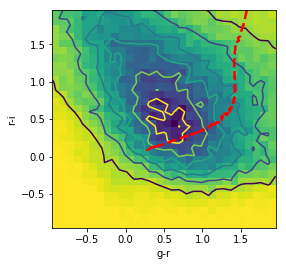

In [30]:
plot_color_color(faint_bump, 'gmr', 'rmi')

(-32.3, -27.2)

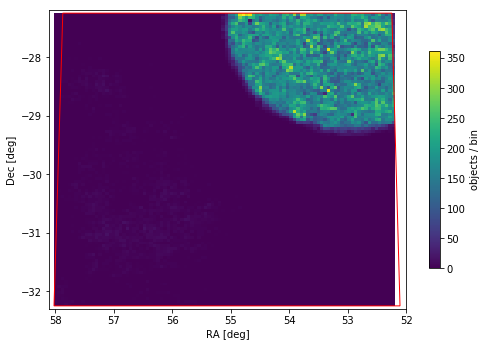

In [31]:
plot_ra_dec(faint_bump)
plt.xlim(58.1, 52.0)
plt.ylim(-32.3, -27.2)

Hmmm... so they're from something in the UDF fields of view.  Naively this region could just be a bit deeper, but the color-color distribution doesn't make any sense.

## Blendedness and Extendedness

In [32]:
w, = np.where(np.isfinite(good['blendedness']))

In [33]:
print(len(good['blendedness']))
print(len(w))

3785814
2925919


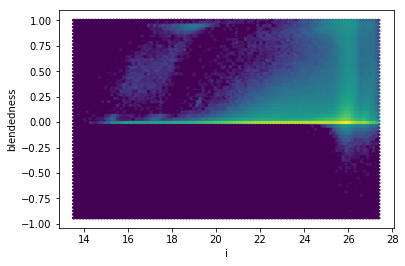

In [34]:
good_blendedness = good[np.isfinite(good['blendedness'])]
plt.hexbin(good_blendedness['mag_i'], good_blendedness['blendedness'],
          bins='log');
plt.xlabel('i')
plt.ylabel('blendedness');

(-0.1, 1.1)

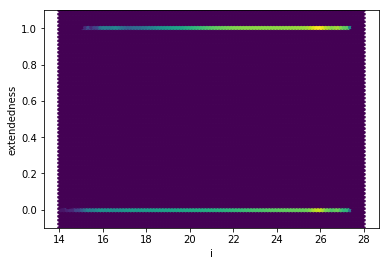

In [37]:
plt.hexbin(good['mag_i'], good['extendedness'],
           extent=(14, 28, -0.1, +1.1),
           bins='log');
plt.xlabel('i')
plt.ylabel('extendedness');
plt.ylim(-0.1, 1.1)

## Shape Parameters
Ixx, Iyy, Ixy

In [107]:
def plot_shape(filt):
    colors = ['blue', 'orange', 'green']
    hist_kwargs = {'color': colors, 'log': True,
             'bins': np.logspace(-1, 1.5, 100),
             'range': (0, 50),
             'histtype': 'step'}
    field = 'Ixx_%s' % filt
    plt.hist([good[field], stars[field], galaxies[field]],
             label=['Ixx all', 'Ixx star', 'Ixx galaxy'],
             linestyle='-',
             **hist_kwargs)
    field = 'Iyy_%s' % filt
    plt.hist([good[field], stars[field], galaxies[field]],
             label=['Iyy all', 'Iyy star', 'Iyy galaxy'],
             linestyle='--',
             **hist_kwargs)
    field = 'Ixy_%s' % filt
    plt.hist([good[field], stars[field], galaxies[field]],
             label=['Ixy all', 'Ixy star', 'Ixy galaxy'],
             linestyle=':',
             **hist_kwargs)


    plt.ylim(100, plt.ylim()[1])
    
    plt.xlabel('Source Momemnts: Ixx, Iyy, Ixy [pixels]')
    plt.ylabel('objects / bin')
    plt.legend()

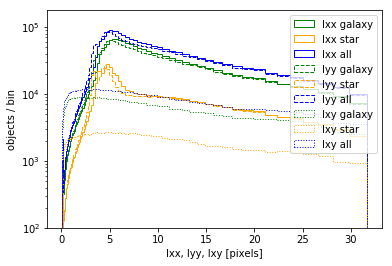

In [108]:
plot_shape('u')

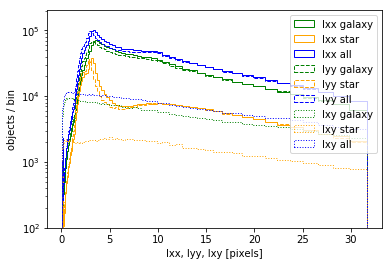

In [109]:
plot_shape('g')

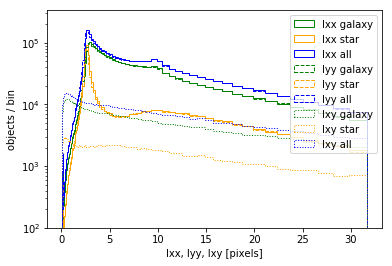

In [110]:
plot_shape('r')

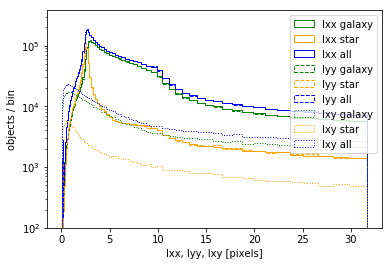

In [111]:
plot_shape('i')

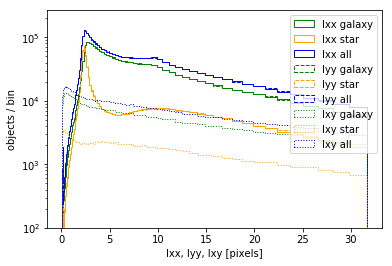

In [112]:
plot_shape('z')

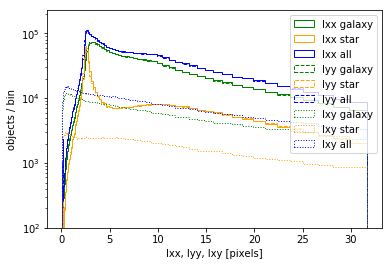

In [113]:
plot_shape('y')

In [159]:
def plot_psf_fwhm(filters=('u', 'g', 'r', 'i', 'z', 'y')):
    for filt in filters:
        psf_fwhm = np.array(good['psf_fwhm_%s' % filt])
        w, = np.where(np.isfinite(psf_fwhm))
        sns.distplot(psf_fwhm[w], label=filt)
    plt.xlabel('PSF FWHM [arcsec]')
    plt.ylabel('objects density / bin')
    plt.legend()

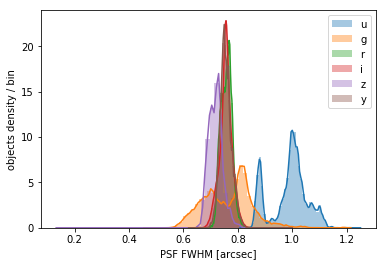

In [160]:
plot_psf_fwhm()